## 1.Correlation ##

In [25]:
import pandas as pd
import numpy as np
from scipy import stats
import os

# ====== Path configuration ======
csv_path = "/Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.csv"
out_path = "/Users/ruoxin/Downloads/dissertation/ghana_facility_grdi_correlations.csv"

# ====== Read data ======
df = pd.read_csv(csv_path)

# ====== Only use specific columns ======
facilities = ["education", "health", "publictransport", "shop", "green"]
grdi_cols = ["GRDI_MEAN"]
index_cols = [f"{f}_index" for f in facilities]

required_cols = ["NAME_2"] + grdi_cols + index_cols
df = df[required_cols].copy()

# ====== type transfer ======
for col in grdi_cols + index_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.replace([np.inf, -np.inf], np.nan)

# ====== correlation analysis======
results = []
for fac in facilities:
    x = df[f"{fac}_index"]
    for grdi_col in grdi_cols:
        y = df[grdi_col]
        mask = x.notna() & y.notna()
        xn, yn = x[mask], y[mask]
        n = len(xn)
        if n >= 3:
            pearson_r, pearson_p = stats.pearsonr(xn, yn)
            spearman_r, spearman_p = stats.spearmanr(xn, yn)
        else:
            pearson_r = pearson_p = spearman_r = spearman_p = np.nan
        results.append({
            "facility": fac,
            "target": grdi_col,
            "N": n,
            "pearson_r": pearson_r,       # Do not round
            "pearson_p": pearson_p,
            "spearman_rho": spearman_r,
            "spearman_p": spearman_p
        })

# ====== Output()======
out_df = pd.DataFrame(results)
out_df = out_df.sort_values(["target", "facility"]).reset_index(drop=True)

# print
with pd.option_context('display.float_format', '{:.3e}'.format):
    print(out_df.to_string(index=False))

# Save()
out_df.to_csv(out_path, index=False, float_format="%.3e")

       facility    target   N  pearson_r  pearson_p  spearman_rho  spearman_p
      education GRDI_MEAN 260 -7.700e-01  2.865e-52    -7.103e-01   3.219e-41
          green GRDI_MEAN 260 -8.186e-01  4.559e-64    -7.462e-01   1.697e-47
         health GRDI_MEAN 260 -8.756e-01  1.688e-83    -6.974e-01   3.356e-39
publictransport GRDI_MEAN 260 -8.199e-01  1.941e-64    -5.885e-01   1.267e-25
           shop GRDI_MEAN 260 -7.989e-01  6.548e-59    -6.669e-01   8.063e-35


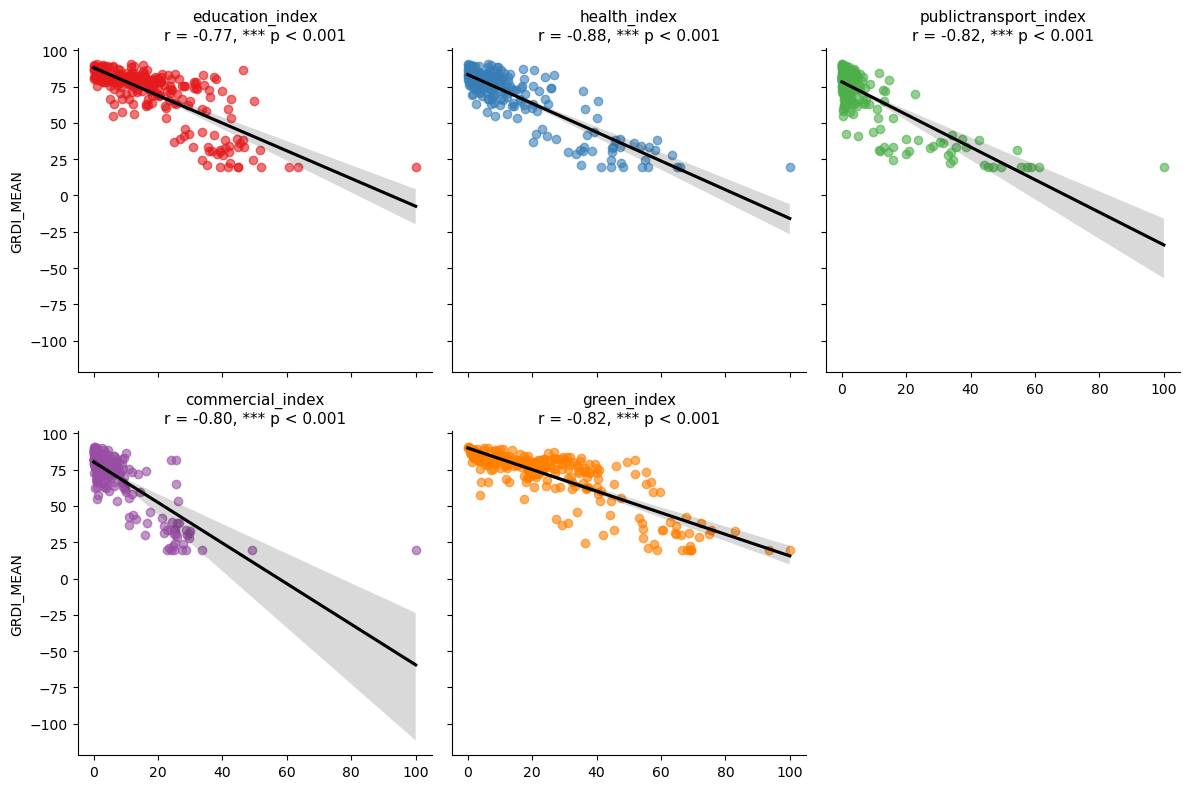

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read data
df = pd.read_csv("ghana_grdi_zonal.csv")  # Replace with your actual path

# Set variables
facilities = ["education_index", "health_index", "publictransport_index", "shop_index", "green_index"]
facility_display_map = {
    "education_index": "education_index",
    "health_index": "health_index",
    "publictransport_index": "publictransport_index",
    "commercial_index": "shop_index",
    "green_index": "green_index"
}
df_melted = df.melt(id_vars=["NAME_2", "GRDI_MEAN"], value_vars=facilities,
                    var_name="Facility Type", value_name="Access Index")
df_melted["Facility Display"] = df_melted["Facility Type"].replace({"shop_index": "commercial_index"})

# Custom colors
facility_palette = {
    "education_index": "# e41a1c",
    "health_index": "# 377eb8",
    "publictransport_index": "# 4daf4a",
    "commercial_index": "# 984ea3",
    "green_index": "# ff7f00"
}

# Compute r and p
correlation_results = {}
for fac in facilities:
    r, p = pearsonr(df[fac], df["GRDI_MEAN"])
    correlation_results[fac] = (r, p)

# Paint
g = sns.FacetGrid(df_melted, col="Facility Display", col_wrap=3, height=4, aspect=1)
for ax, f in zip(g.axes.flat, df_melted["Facility Display"].unique()):
    key = facility_display_map[f]
    color = facility_palette[f]
    subset = df_melted[df_melted["Facility Display"] == f]
    r, _ = correlation_results[key if key != "shop_index" else "shop_index"]
    sns.regplot(data=subset, x="Access Index", y="GRDI_MEAN", ax=ax,
                scatter_kws={"alpha": 0.6, "color": color},
                line_kws={"color": "black"})
    ax.set_title(f"{f}\nr = {r:.2f}, *** p < 0.001", fontsize=11)
    ax.set_xlabel("")
plt.tight_layout()
plt.show()

In [28]:
import pandas as pd
import numpy as np
from scipy import stats

# ====== Path configuration ======
csv_path = "/Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.csv"

# ====== Read data ======
df = pd.read_csv(csv_path)

# ====== extract the required columns ======
cols = ["composite_index", "GRDI_MEAN"]
df = df[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# ====== Function ======
def correlation_summary(x, y):
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]
    n = len(x)
    if n >= 3:
        pearson_r, pearson_p = stats.pearsonr(x, y)
        spearman_r, spearman_p = stats.spearmanr(x, y)
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan
    return {
        "N": n,
        "pearson_r": pearson_r,
        "pearson_p": pearson_p,
        "spearman_rho": spearman_r,
        "spearman_p": spearman_p
    }

x = df["composite_index"]
summary_mean = correlation_summary(x, df["GRDI_MEAN"])

# ====== Output ======
result_df = pd.DataFrame([
    {"target": "GRDI_MEAN", **summary_mean}
])

# ====== Print ======
with pd.option_context('display.float_format', '{:.3e}'.format):
    print(result_df.to_string(index=False))

# ====== Save CSV ======
result_df.to_csv("/Users/ruoxin/Downloads/dissertation/composite_grdi_correlation.csv", index=False, float_format="%.3e")

   target   N  pearson_r  pearson_p  spearman_rho  spearman_p
GRDI_MEAN 260 -8.937e-01  9.126e-92    -7.787e-01   3.732e-54


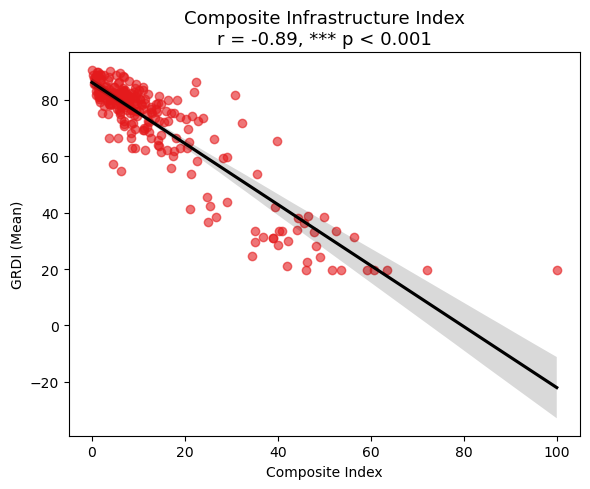

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Read data
df = pd.read_csv("ghana_grdi_zonal.csv")  # Replace with your actual path

# Extract Variable
x = df["composite_index"]
y = df["GRDI_MEAN"]

# Compute Pearson r and p
r, p = pearsonr(x, y)
significance_str = "*** p < 0.001" if p < 0.001 else f"p = {p:.3f}"

# Paint
plt.figure(figsize=(6, 5))
sns.regplot(x=x, y=y, scatter_kws={"alpha": 0.6, "color": "# e41a1c"}, line_kws={"color": "black"})
plt.title(f"Composite Infrastructure Index\nr = {r:.2f}, {significance_str}", fontsize=13)
plt.xlabel("Composite Index")
plt.ylabel("GRDI (Mean)")
plt.tight_layout()
plt.show()

## 2.OLS Regression ##

In [51]:
import pandas as pd
import statsmodels.api as sm
import os

# ====== Path configuration ======
csv_path = "/Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.csv"
out_path = "/Users/ruoxin/Downloads/dissertation/composite_grdi_regression.csv"

# ====== Read and Clean======
df = pd.read_csv(csv_path)
df["composite_index"] = pd.to_numeric(df["composite_index"], errors="coerce")
df["GRDI_MEAN"] = pd.to_numeric(df["GRDI_MEAN"], errors="coerce")
df_clean = df.dropna(subset=["composite_index", "GRDI_MEAN"])

# ====== Regression and Function ======
results = []

def run_ols_and_store(y_col):
    X = df_clean[["composite_index"]]
    X = sm.add_constant(X)
    y = df_clean[y_col]
    model = sm.OLS(y, X).fit()

    intercept = model.params["const"]
    slope = model.params["composite_index"]
    r_squared = model.rsquared
    p_value = model.pvalues["composite_index"]

    #
    sign = "+" if slope >= 0 else "-"
    equation = f"{y_col} = {intercept:.4f} {sign} {abs(slope):.4f} × CompositeIndex"

    print(f"\n===== OLS Regression: {y_col} ~ composite_index =====")
    print(model.summary())

    results.append({
        "target": y_col,
        "intercept": round(intercept, 4),
        "slope": round(slope, 4),
        "R_squared": round(r_squared, 4),
        "p_value": "{:.3e}".format(p_value),
        "equation": equation
    })

run_ols_and_store("GRDI_MEAN")

# ====== Save CSV ======
pd.DataFrame(results).to_csv(out_path, index=False)


===== OLS Regression: GRDI_MEAN ~ composite_index =====
                            OLS Regression Results                            
Dep. Variable:              GRDI_MEAN   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1023.
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           9.13e-92
Time:                        23:36:21   Log-Likelihood:                -915.91
No. Observations:                 260   AIC:                             1836.
Df Residuals:                     258   BIC:                             1843.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

## 3.OLS Residual Moran’s I ##

=== Moran’s I for OLS residuals ===


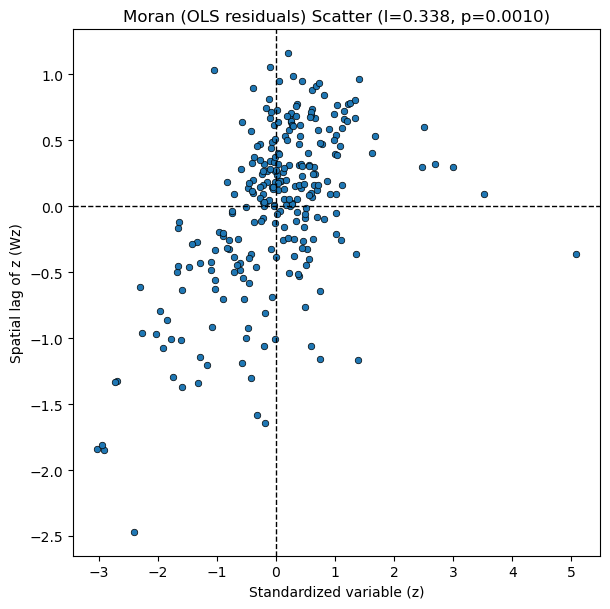

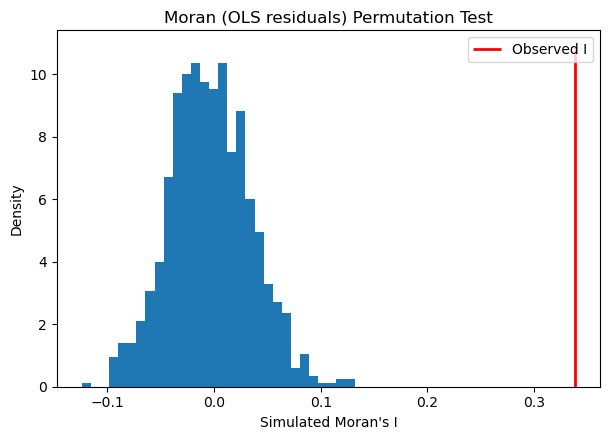

[Moran’s I] I=0.3385, E[I]=-0.0039, p=0.001, z=8.949


In [44]:
# -*- coding: utf-8 -*-
# : OLS residuals Moran's I (with visualization)
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from libpysal.weights import Queen, KNN
from libpysal.weights.spatial_lag import lag_spatial
from esda.moran import Moran
import statsmodels.api as sm

# ===================== Paths and fields =====================
GPKG_PATH = "/Users/ruoxin/Downloads/dissertation/qgis/GHA_2.gpkg"      # Administrative boundaries
CSV_PATH  = "/Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.csv" # variables
JOIN_KEY  = "NAME_2"               # join key
Y_COL     = "GRDI_MEAN"            # defendants 
X_COLS    = ["composite_index"]    # List of covariates; multiple fields allowed
# ===============================================================

# 1) Read and Merge 
gdf = gpd.read_file(GPKG_PATH)
df  = pd.read_csv(CSV_PATH)

gdf[JOIN_KEY] = gdf[JOIN_KEY].astype(str).str.strip()
df[JOIN_KEY]  = df[JOIN_KEY].astype(str).str.strip()
gdf = gdf.merge(df, on=JOIN_KEY, how="inner").reset_index(drop=True)

# 2) Construct Space Weights (Priority Queen; If there is an isolated area, go back KNN)
try:
    w = Queen.from_dataframe(gdf)
    if w.islands:
        print(f"Found：{w.islands}")
        w = KNN.from_dataframe(gdf, k=4)
except Exception as e:
    print("Queen build failed,try KNN", e)
    w = KNN.from_dataframe(gdf, k=4)
w.transform = "r"  # Row-standardize

# 3) : Moran scatterplot(1D)
def moran_plot(series, w, title_prefix="Moran (OLS residuals)", bins=30):
    y = pd.Series(series, dtype=float).replace([np.inf, -np.inf], np.nan).dropna().reset_index(drop=True)
    mi = Moran(y.values, w)

    # Standardization
    z = (y - y.mean()) / y.std(ddof=1)
    wz = pd.Series(lag_spatial(w, z.values))

    # Moran scatterplot
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 6.2))
    ax.scatter(z, wz, edgecolor="k", linewidths=0.5, s=22)
    ax.axhline(0, color="k", linestyle="--", linewidth=1)
    ax.axvline(0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Standardized variable (z)")
    ax.set_ylabel("Spatial lag of z (Wz)")
    ax.set_title(f"{title_prefix} Scatter (I={mi.I:.3f}, p={mi.p_sim:.4f})")
    plt.tight_layout()
    plt.show()

    # Paint
    fig, ax = plt.subplots(1, 1, figsize=(6.2, 4.5))
    ax.hist(mi.sim, bins=bins, density=True)
    ax.vlines(mi.I, 0, ax.get_ylim()[1], color="red", linewidth=2, label="Observed I")
    ax.set_xlabel("Simulated Moran's I")
    ax.set_ylabel("Density")
    ax.set_title(f"{title_prefix} Permutation Test")
    ax.legend()
    plt.tight_layout()
    plt.show()

    print(f"[Moran’s I] I={mi.I:.4f}, E[I]={mi.EI:.4f}, p={mi.p_sim:.4g}, z={mi.z_norm:.3f}")
    return mi

# 4) : OLS Moran's I
Y = gdf[Y_COL].astype(float)
X = gdf[X_COLS].astype(float)
X = sm.add_constant(X)

ols = sm.OLS(Y, X).fit()

resid = ols.resid.values
print("=== Moran’s I for OLS residuals ===")
mi_resid = moran_plot(resid, w, title_prefix="Moran (OLS residuals)")

## 4.SEM ##

In [53]:
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import pandas as pd
import numpy as np

# PySAL / spreg
from libpysal.weights import Queen, Rook
from libpysal import weights
from esda.moran import Moran
from spreg import ML_Error, GM_Error, GM_Error_Het  # SEM variants

# ========= 1) Read data =========
gpkg_path = "/Users/ruoxin/Downloads/dissertation/qgis/GHA_2.gpkg"                 # Your admin2 boundaries (GeoPackage or Shapefile/GeoJSON)
csv_path  = "/Users/ruoxin/Downloads/dissertation/ghana_grdi_zonal.csv"       # Your indicator table

gdf = gpd.read_file(gpkg_path)[["NAME_2","geometry"]].copy()
df  = pd.read_csv(csv_path)

# unify()
key = "NAME_2"
df[key] = df[key].astype(str).str.strip()
gdf[key] = gdf[key].astype(str).str.strip()

data = gdf.merge(df, on=key, how="inner")

# ========= 2) Dependants & Independent variables =========
# (GRDI): GRDI_MEAN
y_col = "GRDI_MEAN"
# Covariates: minimally use composite_index; optionally add controls (beware multicollinearity)
X_cols = ["composite_index"]  # ; : ["composite_index","education_index","health_index",...]

# Discard
model_df = data[[y_col] + X_cols].replace([np.inf, -np.inf], np.nan).dropna().copy()
data = data.loc[model_df.index].reset_index(drop=True)
model_df = model_df.reset_index(drop=True)

# ========= 3) (Queen contiguity)=========
# If polygons have self-intersections/geometry errors, first fix with data = data.buffer(0)
W = Queen.from_dataframe(data)   # Rook.from_dataframe(data)
W.transform = "r"                # Row-standardize

# ========= 4) Assemble matrices =========
# spreg expects numpy arrays
y = model_df[[y_col]].values
X = model_df[X_cols].values

# ========= 5) Baseline OLS residuals Morans I (optional)=========
moran_ols = None
try:
    import statsmodels.api as sm
    ols_fit = sm.OLS(y, sm.add_constant(X)).fit()
    residuals = np.asarray(ols_fit.resid).reshape(-1,1)
    moran_ols = Moran(residuals, W)
    print(f"[OLS Residual Moran’s I] I={moran_ols.I:.4f}, p={moran_ols.p_sim:.4f}")
except Exception as e:
    print("Failed: ", e)

# ========= 6) Run Spatial Error Model (SEM)=========
# 6.1 ML-Error
ml_sem = ML_Error(y, X, w=W, name_y=y_col, name_x=X_cols, name_w="Queen", spat_diag=True, name_ds="Ghana_L2")
print("\n=== ML-Error (SEM) ===")
print(ml_sem.summary)

# 6.2 GM-Error
gm_sem = GM_Error(y, X, w=W, name_y=y_col, name_x=X_cols, name_w="Queen", name_ds="Ghana_L2")
print("\n=== GM-Error (SEM, GMM) ===")
print(gm_sem.summary)

# 6.3 GM-Error-Het
gm_sem_het = GM_Error_Het(y, X, w=W, name_y=y_col, name_x=X_cols, name_w="Queen", name_ds="Ghana_L2")
print("\n=== GM-Error-Het (SEM, GMM-Het-robust) ===")
print(gm_sem_het.summary)

# ========= 7) Extract key results =========
def tidy_sem_result(res):
    out = {
        "lambda": getattr(res, "lam", np.nan),
        "lambda_p": getattr(res, "lam_p_value", np.nan) if hasattr(res, "lam_p_value") else np.nan,
        "AIC": getattr(res, "aic", np.nan) if hasattr(res, "aic") else np.nan,
        "logll": getattr(res, "logll", np.nan) if hasattr(res, "logll") else np.nan,
        "n": getattr(res, "n", len(y)),
        "k": getattr(res, "k", X.shape[1]+1),  # +1 for intercept if any
    }
    
    try:
        names = res.name_x
        betas = res.betas.flatten()
        # Order of betas: constant + X columns
        out["intercept"] = betas[0]
        for i, name in enumerate(names, start=1):
            out[f"beta_{name}"] = betas[i]
    except Exception:
        pass
    return out

print("\n--- Key numbers (for writing) ---")
print("ML-Error:", tidy_sem_result(ml_sem))
print("GM-Error:", tidy_sem_result(gm_sem))
print("GM-Error-Het:", tidy_sem_result(gm_sem_het))

# ========= 8)check Morans I of SEM residuals =========
try:
    # ML-Error residuals
    res_ml = ml_sem.u  # residuals
    moran_ml = Moran(res_ml.reshape(-1,1), W)
    print(f"\n[SEM Residual Moran’s I] I={moran_ml.I:.4f}, p={moran_ml.p_sim:.4f}")
except Exception as e:
    print("Failed: ", e)

[OLS Residual Moran’s I] I=0.3385, p=0.0010

=== ML-Error (SEM) ===
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :    Ghana_L2
Weights matrix      :       Queen
Dependent Variable  :   GRDI_MEAN                Number of Observations:         260
Mean dependent var  :     71.1446                Number of Variables   :           2
S.D. dependent var  :     18.3023                Degrees of Freedom    :         258
Pseudo R-squared    :      0.7986
Log likelihood      :   -847.3578
Sigma-square ML     :     31.5823                Akaike info criterion :    1698.716
S.E of regression   :      5.6198                Schwarz criterion     :    1705.837

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------